In [7]:
pwd

'/storage/kgalentino/TEST-FINAL-CHEMFLOW/ChemFlow_tutorial_a-thrombin'

In [8]:
import pandas as pd

In [9]:
docking = pd.read_csv('tutorial_chemflow/DockFlow/plants/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
implicitspinglepoint = pd.read_csv('tutorial_chemflow/ScoreFlow/mmgbsa/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
implicitMD = pd.read_csv('tutorial_chemflow/ScoreFlow/mmgbsa_md/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)
explicitMD = pd.read_csv('tutorial_chemflow/ScoreFlow/explicit_mmgbsa/vmd-rec/SORTED-uniq-lig.csv', delim_whitespace=True)



In [10]:
alldfs=[docking, implicitspinglepoint, implicitMD, explicitMD]

In [11]:
# Let's remove the second column with the names of our ligand. They are already specified in the first one!

for i in alldfs:
    i.drop(columns=['LIGAND.1'], inplace=True)

In [12]:
# Let's rename the column SCORE/RMSD(SMINA-MIN) in simply "SCORE" for comodity in the dataframe docking

docking.rename(
    columns={'SCORE/RMSD(SMINA-MIN)':"SCORE"}
          ,inplace=True)
    

In [13]:
#Let's make our negative scores positive, in order to do not have problems later on

for i in alldfs:
    i['SCORE'] = i['SCORE']*-1 
    

In [15]:
# Let's create a new column in each dataframe in which we specify the initial letter of the LIGAND name.
# This is needed to classify our compounds in true active or decoys. 
# We know that the names of our decoys start with a 'C'

for i in alldfs:
    ii = i
    ii['letter'] = i['LIGAND'].str[:1]
    classification = []
    for row in ii['letter']:
        if row == 'C' : classification.append('0') # classification for decoys
        elif row != 'C' :   classification.append('1') # classification for actives
        else:           classification.append('Error')
    ii['classification'] = classification 
    

In [17]:
# Let's convert class pandas core series of the column classification into int

import numpy as np
for x in alldfs:
    x['classification'] = x['classification'].astype(int)
    y_true = np.array(x['classification'])
    print(y_true)


[1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
[1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
[1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0]
[1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0]


In [18]:
# Let's define the function to generate Receiver operating characteristics (ROC) 
# The number of true actives is 7 and the number of decoys in our dataset is 14. 
# If you work with different datasets remmeber to modify these values!

def roc_tutorial(df, actives=7, decoys=14):
    tp = 0
    fp = 0
    tpr = []
    fpr = []

    for c in df['classification']: 
        if c == 1:
            tp+=1
        elif c == 0:
            fp+=1
        tpr.append(tp/actives)
        fpr.append(fp/decoys)
   
    
    return tpr, fpr
    

In [19]:
# Let's run the roc_tutorial function for the different rescoring procedures and for the docking

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

#PLANTS
aucdocking = metrics.roc_auc_score(docking['classification'],  docking['SCORE'])

tprdocking, fprdocking = roc_tutorial(docking)


#implicit mmgbsa single point (ISP)
aucISP = metrics.roc_auc_score(implicitspinglepoint['classification'],  implicitspinglepoint['SCORE'])

tprISP, fprISP = roc_tutorial(implicitspinglepoint)

#implicit mmgbsa MD

aucIMD = metrics.roc_auc_score(implicitMD['classification'],  implicitMD['SCORE'])

tprIMD, fprIMD = roc_tutorial(implicitMD)

#explicit mmgbsa MD

aucEMD = metrics.roc_auc_score(explicitMD['classification'],  explicitMD['SCORE'])

tprEMD, fprEMD = roc_tutorial(explicitMD)



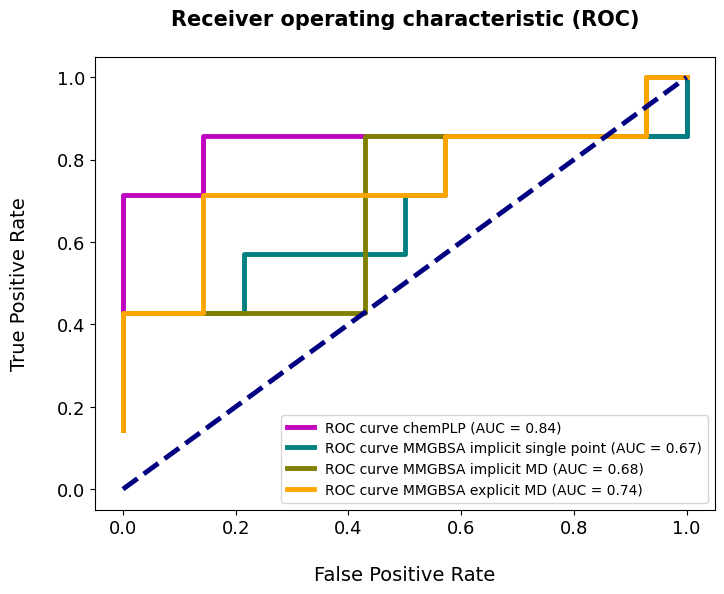

In [27]:
# PLOT the ROC and AUC for all the protocols and save the png file 

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=100)

lw = 3.5

plt.plot(fprdocking,tprdocking,label="ROC curve chemPLP (AUC = %0.2f)" % aucdocking, color = 'm', lw =lw)

plt.plot(fprISP,tprISP,label="ROC curve MMGBSA implicit single point (AUC = %0.2f)" % aucISP, color = 'teal', lw =lw)

plt.plot(fprIMD,tprIMD,label="ROC curve MMGBSA implicit MD (AUC = %0.2f)" % aucIMD, color = 'olive', lw =lw)

plt.plot(fprEMD,tprEMD,label="ROC curve MMGBSA explicit MD (AUC = %0.2f)" % aucEMD, color = 'orange', lw =lw)


plt.title("Receiver operating characteristic (ROC)\n", fontweight="bold", fontsize =15)

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")

plt.tick_params(axis='both', labelsize=13)

plt.xlabel("\nFalse Positive Rate",fontsize =14)

plt.ylabel("True Positive Rate\n",fontsize =14)

plt.legend(loc='best')

plt.savefig("ROC-chemplp-mmgbsa-imp-exp.png", dpi=300, facecolor='white', transparent=False)